# Sufficiency

### Imports

In [1]:
import pandas as pd
import numpy as np
import random

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib import patches as mpatches
from mpl_toolkits.basemap import Basemap

import seaborn as sns

import os, sys

import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import pickle

from mpl_toolkits.basemap import Basemap

import xlsxwriter

### Set constants

In [2]:
# Value to change to get correct paths
data_path = 'data/'

In [3]:
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_no_irrig_path = intermediate_path + 'Baseline_df_iterations/'
data_2000_path = intermediate_path + 'Baseline_df_iterations/with_irrig/'

#data_2050_no_irrig_path = intermediate_path + 'Future_dfs/All_change/'
data_2050_path = intermediate_path + 'Future_dfs/All_change+irrig/'

data_2050_gdp_cont_path = data_2050_path + 'gdp_cont/original/'
data_2050_gdp_income_path = data_2050_path + 'gdp_cat_income/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'

data_2050_gdp_cont_clustered_path = data_2050_path + 'gdp_cont/clustered/'
data_2050_gdp_income_clustered_path = data_2050_path + 'gdp_cat_income/clustered/'
data_2050_gdp_stat_clustered_path = data_2050_path + 'gdp_cat_stat/clustered/'

model_output_path = output_path + 'model_output/'
composite_path = output_path + 'composite/'
compare_path = output_path + 'compare/'
suff_path = output_path + 'sufficiency/'


figure_path = 'figures/with_irrig/'
dist_figures_path = figure_path + 'distributions/'
agg_assumption_fig_path = figure_path + 'agg_assumption/'
cluster_fig_path = figure_path + 'clusters/'
convex_hull_fig_path = figure_path + 'convex_hull/'
suff_fig_path = figure_path + 'sufficiency/'
model_fig_path = figure_path + 'models/'
sensitivity_fig_path = figure_path + 'sensitivity/'

model_path = data_path + 'models/'

In [4]:
files_2050 = os.listdir(data_2050_gdp_cont_path)
files_2050 = [filename for filename in files_2050 if 'ssp' in filename]

climate_models, climate_scenarios = [], []

for file in files_2050:
    if len(file) == 11:
        climate_models.append(file[:2])
        climate_scenarios.append(file[3:7])

climate_models = list(set(climate_models))
climate_models.sort()
climate_scenarios = list(set(climate_scenarios))
climate_scenarios.sort()
climate_models, climate_scenarios

(['cc', 'gs', 'he', 'mr'], ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'])

## Country sufficiency

### Compute

In [323]:
caloric_req = 2320*1e3*365.25

In [324]:
# Population 
def get_total_pop(ssp):
    '''ssp: 2000 or ssp'''
    pop_dir = inputs_path + 'population/'
    pop = pd.read_csv(os.path.join(pop_dir, 'pop_' + ssp + '.csv'))
    pop = pop.set_index('pixel_id')
    pop_tot = pop['gpw_population'].sum()
    return pop_tot

In [325]:
def get_total_prod(ssp):
    '''ssp: 2000 or ssp'''
    results_dir = compare_path
    if ssp == '2000':
        rez = pd.read_csv(os.path.join(results_dir, 'ssp1_compare.csv')) 
        return rez['calories_2000'].sum()
    else:
        rez = pd.read_csv(os.path.join(results_dir, ssp + '_compare.csv'))
        rez = rez.set_index('pixel_id')
        return rez['calories_2050'].sum()

In [326]:
def calc_CalSuff(prod_available, LS, pop,
            caloric_req = (2320*1e3*365.25) #in cal/capita/yr
           ):
    ''' prod_available (for Food not Feed + accounting for losses) - in Calories
        LS : animal calories availables
        pop : in capita
        caloric_req : default values is ADER=2320 kcal/cap/d (without fish)
        
        This is all per year
    '''
    return (prod_available + LS) / (caloric_req * pop)

#### 2000

In [327]:
# Percetenge live stock in 2000
pctLS_2000 = .19
# Live stock value in 2000
LS_2000 = 1.1483e15*1e3 #calories
# Precentage of production used as food
pct_Prod_Food_2000 = .52

pop_2000 = get_total_pop('2000')
prod_2000 = get_total_prod('2000') # calories

In [328]:
LS_2000

1.1483e+18

In [329]:
# Quantity of food available in 2000 as food
prod_available_2000 = prod_2000*pct_Prod_Food_2000

# 2000 caloric sufficiency
global_CalSuff_2000 = calc_CalSuff(prod_available_2000,
                       LS_2000,
                       pop_2000)

global_CalSuff_2000

1.9568954103348346

#### 2050

In [330]:
feed_conversion_factor = 2.3

# Data source: Bodirsky : share of calories in diet from animal products
pctLS_2050 = .19 #Assuming cst

In [331]:
def global_CalSuff_2050(ssp,
                        pctLS_2050 = .19):
    
    prod_2050 = get_total_prod(ssp)
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food_2000 + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food_2000 + feed_now_food
    
    pop = get_total_pop(ssp)

    calsuff = calc_CalSuff(prod_available,
                           LS_2050,
                           pop)
    
    return calsuff

In [332]:
global_CalSuff_2000

1.9568954103348346

In [333]:
# Global caloric sufficiency for each spp
for ssp in climate_scenarios:
    print(ssp, global_CalSuff_2050(ssp))

ssp1 1.5112323887526444
ssp2 1.5501459287019408
ssp3 1.2827715529529145
ssp4 1.4490819281406666
ssp5 1.5758471267364784


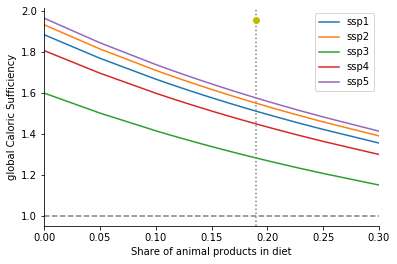

In [334]:
CalSuff_df = pd.DataFrame(columns=['ssp','global_CalSuff','pctLS'])

for ssp in climate_scenarios:
    for pctLS_2050 in [0,.05,.1,.11,.12,.13,.14,.15,.16,.17,.18,.19,.20,.21,.22,.23,.25,.30]:
        
        CalSuff = global_CalSuff_2050(ssp,
                                     pctLS_2050)

        CalSuff_df = CalSuff_df.append({'ssp':ssp,'global_CalSuff':CalSuff,'pctLS':pctLS_2050},ignore_index=True)

fig, ax = plt.subplots()

for ssp, grp in CalSuff_df.groupby(['ssp']):
    ax = grp.plot(ax=ax, kind='line', x='pctLS', y='global_CalSuff', label=ssp)

plt.axvline(x=.19,linestyle=':',color='grey')
plt.axhline(y=1,linestyle='--',color='grey')

# Baseline
plt.plot(.19, global_CalSuff_2000, 'yo') 

#Prettify
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('global Caloric Sufficiency');
plt.xlabel('Share of animal products in diet');
plt.legend(loc='best');

#### By country 2000

In [335]:
# Country of each pixel
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')

In [336]:
countries.head()

,country_id,base_id,ISO3,name,sovereignt
pixel_id,,,,,
330087.0,91.0,91,GRL,Greenland,Denmark
330088.0,91.0,91,GRL,Greenland,Denmark
330089.0,91.0,91,GRL,Greenland,Denmark
330090.0,91.0,91,GRL,Greenland,Denmark
334378.0,91.0,91,GRL,Greenland,Denmark


In [337]:
# 2000 diet data FAOSTAT
diet_2000 = pd.read_csv(diet_path + 'Consumption_2000_FAOSTAT.csv')

In [338]:
# LS 2000 Data with countries
LS_2000_df = diet_2000[diet_2000['Item']=='Animal Products'][['Country','Value']].merge(countries[['name','ISO3']].drop_duplicates(),
                                                                                        right_on='name',left_on='Country',how='left')
# kcal/capita/day to cal/capita
LS_2000_df['LS2000_percapita'] = LS_2000_df['Value'].apply(lambda x:x*1e3*365.25)



LS_2000_df = LS_2000_df[['name','ISO3','LS2000_percapita']].set_index('ISO3')

In [339]:
# Population by country
pop_dir = pop_path
pop = pd.read_csv(os.path.join(pop_dir,'pop_2000.csv'))
pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
pop_bycountry_2000 = pop.groupby('ISO3')['gpw_population'].sum()
total_pop_2000 = pop['gpw_population'].sum()

# Production by country
prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
prod_bycountry = prod.groupby('ISO3')['calories_2000'].sum()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [340]:
# List of all countries
countries_list = pop_bycountry_2000[pop_bycountry_2000>0].index

In [341]:
len(countries_list)

229

In [342]:
calsuff_numerator = 0
pct_Prod_Food_2000 = .52

for country in countries_list:
    # Production of country
    prod_country = prod_bycountry[country]
            
    # LS 2000
    try:
        # Get value from data
        LS2000 = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry_2000[country]
    except KeyError:
        try:
            # Get value from sovereignt country
            sovereignt_country = countries[countries['ISO3'] == country].drop_duplicates()['sovereignt']
            sovereignt_iso = countries[countries['sovereignt'] == sovereignt_country].drop_duplicates()['ISO3']
            print(country, sovereignt_iso)
            LS2000 = LS_2000_df.at[sovereignt_c,'LS2000_percapita'] * pop_bycountry_2000[sovereignt_c]
        except:
            # Calculate value from total consumption
            LS2000 = LS_2000 / total_pop_2000 * pop_bycountry_2000[country]
        
    
    # Caloric sufficiency's numerator
    calsuff_numerator += ((prod_country * pct_Prod_Food_2000)+LS2000)
    

global_calsuff_2000 = calsuff_numerator/(caloric_req*pop['gpw_population'].sum())
global_calsuff_2000

1.9273473022544423

We see that the global caloric sufficiency here when aggregated by country is smaller than the one computed with the pixels themselves

In [343]:
LS_2000_df_country = pd.DataFrame(index=countries_list, columns=['LS_2000'])
for country in countries_list:
    try:
        LS_2000_df_country.loc[country, 'LS_2000'] = LS_2000_df.at[country,'LS2000_percapita'] * pop_bycountry_2000[country]
        
    except: 
        try: 
            # Get value from sovereignt country
            sovereignt_country = countries[countries['ISO3'] == country].drop_duplicates()['sovereignt']
            sovereignt_iso = countries[countries['sovereignt'] == sovereignt_country].drop_duplicates()['ISO3']
            print(country, sovereignt_iso)
            LS_2000_df_country.loc[country, 'LS_2000'] = LS_2000_df.at[sovereignt_c,'LS2000_percapita'] * pop_bycountry_2000[sovereignt_c]
            
            
        except: 
            LS_2000_df_country.loc[country, 'LS_2000'] = LS_2000 / total_pop_2000 * pop_bycountry_2000[country]
            

In [344]:
LS_2000_df_country.head()

,LS_2000
ISO3,
AFG,1.98416e+15
AGO,8.49493e+14
ALB,7.4152e+14
ALD,2.71716e+12
AND,1.01852e+13


In [345]:
# Compute sufficiencies of each country

sufficiencies = pd.DataFrame()

# sufficiency 2000
df = pd.concat([prod_bycountry, pop_bycountry_2000], axis=1)
df = df[df['calories_2000'] > 0]
suff_country = df.apply(lambda r: calc_CalSuff(r['calories_2000']*pct_Prod_Food_2000, LS_2000_df_country.at[r.name, 'LS_2000'], r['gpw_population']), axis=1).replace([np.inf, -np.inf], np.nan)

sufficiencies['2000'] = suff_country
sufficiencies.loc[df[df['calories_2000'] <= 0].index, '2000'] = np.nan

sufficiencies.head()

,2000
ISO3,
AFG,0.785233
AGO,0.597733
ALB,2.319537
ARE,0.403014
ARG,8.343864


In [346]:
# The countries where we could retrieve the sufficiency
len(sufficiencies)

168

#### By country 2050

In [347]:
def calc_CalSuff_numerator_2050(LS_2000_c,
                      pct_LS_2050,
                      prod_2050):
    
    LS_2050 = pct_LS_2050 * (prod_2050 * pct_Prod_Food_2000 + feed_conversion_factor * LS_2000_c) / (1 + pct_LS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000_c - LS_2050)
    
    prod_available = prod_2050 * pct_Prod_Food_2000 + feed_now_food
    
    return (prod_available+LS_2050)

In [348]:
# Load diets data
diets = pd.read_csv(diet_path + 'pctLS_SSPs_Bodirsky.csv',sep=';')

for ssp in climate_scenarios:

    # Population by country
    pop_dir = pop_path
    pop = pd.read_csv(os.path.join(pop_dir, 'pop_' + ssp + '.csv'))
    pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
    pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()
    
    total_pop_2050 = pop['gpw_population'].sum()
        
    # Production by country
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id')
    #prod = prod.merge(countries, right_on='pixel_id', left_on='pixel_id')
    prod_bycountry = prod.groupby('ISO3')['calories_2050'].sum()
    
    calsuff_numerator = 0
    suff_c = pd.Series()
    for country in countries_list:
        pr = 0
        suff_nan = False
        # Diet
        try:
            # Get from the data
            pct_LS_2050 = diets[(diets['Scenario'] == ssp) & (diets['Region'] == country)]['2050'].values[0]
        except IndexError:
            #print(countries[countries['ISO3'] == country].name.values[0])
            # Assume percentage constant as defined before if value not in data
            pct_LS_2050 = 0.19
        
        # Production
        prod_country = prod_bycountry[country]
        
        # Caloric sufficiency
        num = calc_CalSuff_numerator_2050(LS_2000_df_country.at[country, 'LS_2000'],
                                          pct_LS_2050,
                                          prod_2050=prod_country)
        
        calsuff_numerator += num
                
        # sufficiency of the country
        suff_c[country] = num/(caloric_req*pop_bycountry[country])
    
    sufficiencies[ssp] = suff_c

sufficiencies = sufficiencies.rename({'Unnamed: 0': 'ISO3'}, axis=1)
# Drop ESB, CNM
sufficiencies = sufficiencies[~sufficiencies.index.isin(['ESB', 'CNM'])]
# Uncomment if to save new version
#sufficiencies.replace(0, np.nan).to_csv(suff_path + 'country_sufficiencies.csv')

In [349]:
sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv')
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429


In [350]:
sufficiencies[sufficiencies['ISO3'] == 'JPN']

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5
75,JPN,0.793248,0.998118,0.933332,0.904337,0.997438,0.943213


In [351]:
def visualize_sufficiency(suff, scenario, fig, ax, title, shape=(2160, 4320), savefig=False):
    bins = [0, 50, 100, 150, 200, np.inf]
    indexes = suff.index
    # Create the bins
    suff = pd.cut(suff, bins=bins, labels=range(1, len(bins)))
    suff_array = np.zeros((shape[0]*shape[1],))
    suff_array[indexes] = suff.values
    suff_df = pd.DataFrame(suff_array, columns=['label'])
        
    c_list = ['white', 'red', 'orange', '#ADFF2F', '#32CD32', '#556B2F']
    cmap = colors.ListedColormap(c_list, name='my_colormap_name')
    
    legend = []
    legend.append(mpatches.Patch(color='red', label='Less than 50%'))
    legend.append(mpatches.Patch(color='orange', label='50 to 100%'))
    legend.append(mpatches.Patch(color='#ADFF2F', label='100 to 150%'))
    legend.append(mpatches.Patch(color='#32CD32', label='150 to 200%'))
    legend.append(mpatches.Patch(color='#556B2F', label='More than 200%'))
    
    #Plot data
    
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), cmap=cmap, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    plt.legend(handles=legend, loc=3)
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + scenario + '.png', dpi=500)

ssp1


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


ssp2
ssp3
ssp4
ssp5


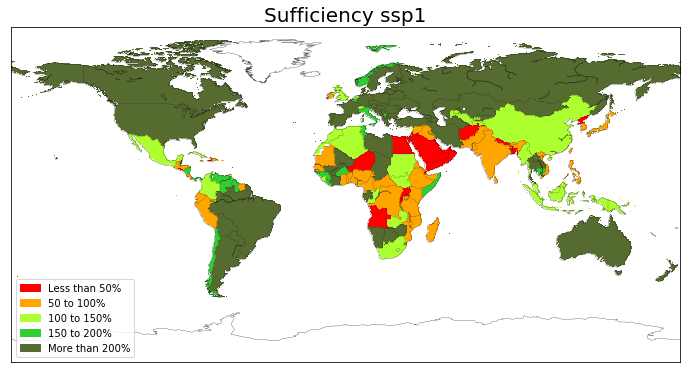

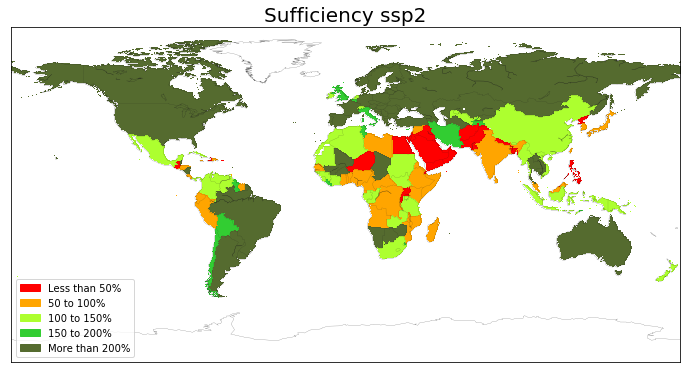

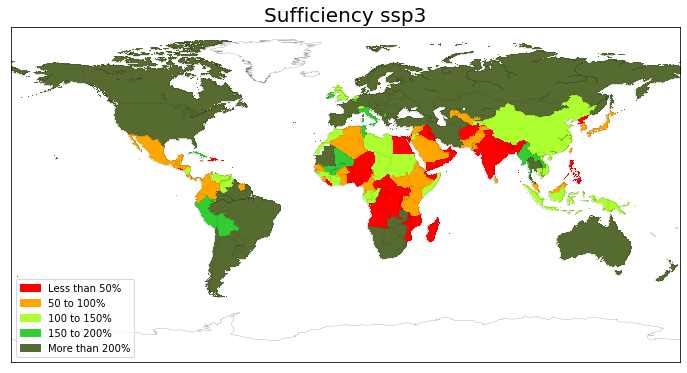

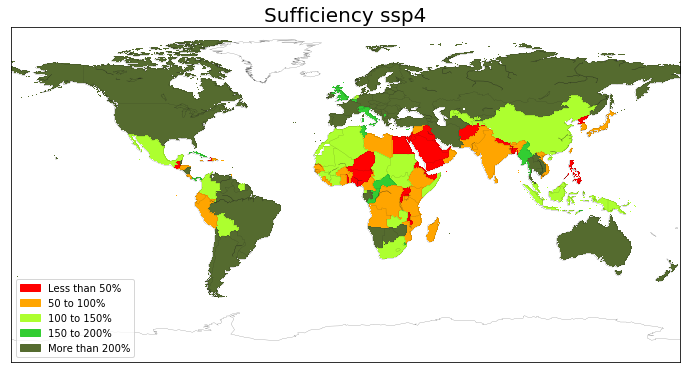

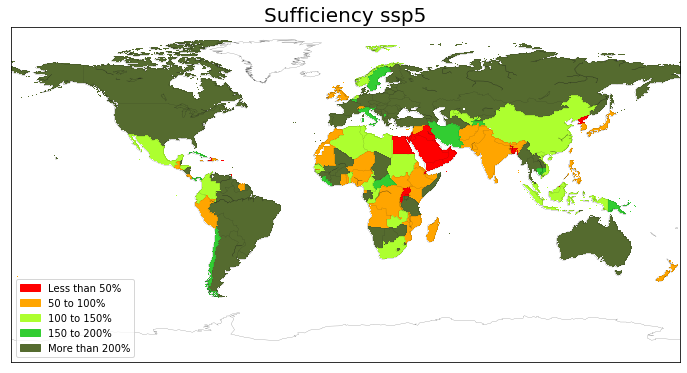

In [352]:
# Show map of sufficiency for every ssp
for ssp in climate_scenarios:
    print(ssp)
    fig, ax = plt.subplots(figsize=(12, 8))
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
    suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')
    
    if ssp == 'ssp1':
        title_2000 = 'Sufficiency 2000'
        suff_2000 = suff_all['2000']
        visualize_sufficiency(suff_2000*100, '2000', fig, ax, title_2000, savefig=True)

    title = 'Sufficiency ' + ssp
    suff = suff_all[ssp]
    visualize_sufficiency(suff*100, ssp, fig, ax, title, savefig=False)

ssp1


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


ssp2
ssp3
ssp4
ssp5


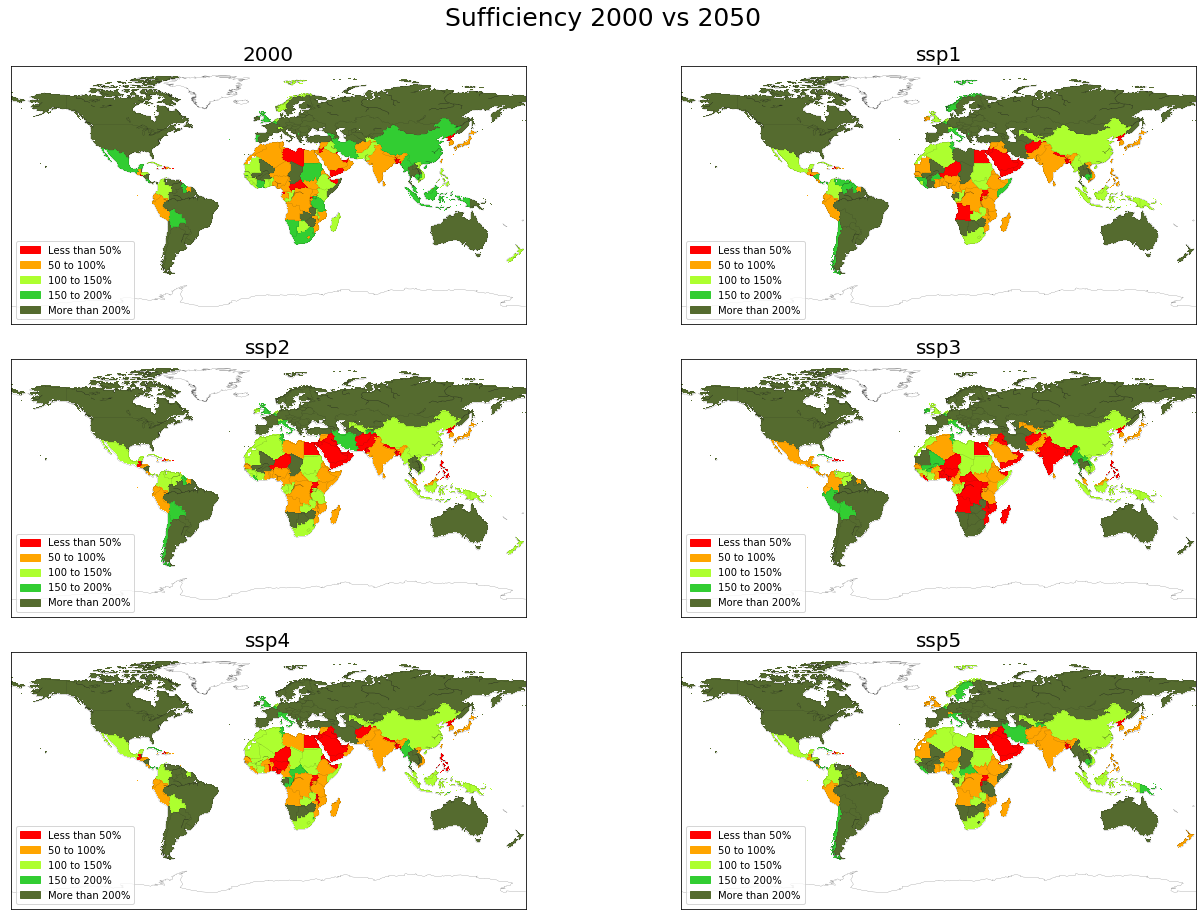

In [353]:
# Plot 6 sufficiency maps on the same figure
fig = plt.figure(figsize=(20, 13))
fig.suptitle('Sufficiency 2000 vs 2050', fontsize=25)

for i, ssp in enumerate(climate_scenarios): 
    print(ssp)
    prod = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
    suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')
    
    if ssp == 'ssp1':
        title_2000 = '2000'
        ax = plt.subplot(321)
        suff_2000 = suff_all['2000']
        visualize_sufficiency(suff_2000*100, ssp, fig, ax, title_2000, savefig=False)

    ax = plt.subplot(321 + i + 1)
    title = ssp
    suff = suff_all[ssp]
    visualize_sufficiency(suff*100, ssp, fig, ax, title, savefig=False)
    
fig.tight_layout(rect=[0, 0, 1, 0.95])
#fig.savefig(suff_fig_path + 'sufficiencies' + '.png', dpi=500)

## Aggregate sufficiencies

In [6]:
sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv')

In [11]:
def visualize_sufficiency_all(suff, fig, ax, title, shape=(2160, 4320), savefig=False):
    suff_array = np.zeros((shape[0]*shape[1],)) - 1
    suff_array[suff.index] = suff['all_ssp'].values
    suff_df = pd.DataFrame(suff_array)
        
    c_list = ['red', 'orange', 'pink', '#0D98BA', 'green']
    cmap = colors.ListedColormap(c_list, name='my_colormap_name')
    cmap.set_under('w')
    
    legend = []
    legend.append(mpatches.Patch(color='red', label='Down in all'))
    legend.append(mpatches.Patch(color='orange', label='Down in most'))
    legend.append(mpatches.Patch(color='pink', label='Variable'))
    legend.append(mpatches.Patch(color='#0D98BA', label='Up in most'))
    legend.append(mpatches.Patch(color='green', label='Up in all'))
    
    #Plot data
    
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), vmin=0, cmap=cmap, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    plt.legend(handles=legend, loc=3)
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + 'all_ssp' + '.png', dpi=500)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


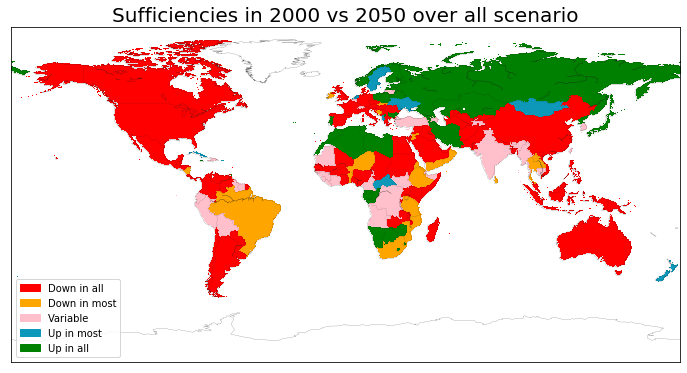

In [12]:
# Cases: 
#-1: no info

#0: down in all scenario (Red)
#1: down in most scenario (Orange)

# in 2/3 scenarios
#2: variable (Pink)

# in 4 scenarios
#3: up in most scenario (Blue-Green)
#4: up in all scenario (Green)

fig, ax = plt.subplots(figsize=(12, 8))

sufficiencies['all_ssp'] = -1
for i, country in sufficiencies.iterrows():
    state = -1
    val_2000 = country['2000']   
    down = 0
    up = 0
    num_nan = 0
    for ssp in climate_scenarios:
        if (country[ssp] == np.nan) or (val_2000 == np.nan):
            num_nan += 1
        # not significant if not change of 0.1 unit of sufficiency
        # 2050 pred less than 2000 sufficiency
        elif country[ssp] - val_2000 < -0.1:
            down += 1
        # 2050 pred more than 2000 sufficinecy
        elif country[ssp] - val_2000 >= 0.1:
            up += 1
    
    # Compare diff values
    # Case 
    if up == 5 - num_nan: state = 4     #4: up all scenarios
    elif down == 5 - num_nan: state = 0    #0: down all scenarios
    elif up == 4 - num_nan: state = 3     #3: up most
    elif down == 4 - num_nan: state = 1    #1: down most
    else: state = 2     #2: variable (Pink)
    
    sufficiencies.at[i, 'all_ssp'] = state
            

prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')

title = 'Sufficiencies in 2000 vs 2050 over all scenario'
visualize_sufficiency_all(suff_all, fig, ax, title, savefig=False)

In [367]:
def visualize_sufficiency_below(suff, fig, ax, title, shape=(2160, 4320), savefig=False):
    suff_array = np.zeros((shape[0]*shape[1],)) - 1
    suff_array[suff.index] = suff['get_below'].values
    suff_df = pd.DataFrame(suff_array)
        
    c_list = ['red', 'orange', 'purple', 'violet', 'beige']
    cmap = colors.ListedColormap(c_list, name='my_colormap_name')
    cmap.set_under('w')
    
    legend = []
    legend.append(mpatches.Patch(color='red', label='Gets below 1 in all'))
    legend.append(mpatches.Patch(color='orange', label='Gets below 1 in most'))
    legend.append(mpatches.Patch(color='purple', label='Was and is still below 1 in all'))
    legend.append(mpatches.Patch(color='violet', label='Was and is still below 1 in most'))
    
    
    #Plot data
    
    data = suff_df.values
    bm = Basemap()
    
    im = bm.imshow(np.flipud(data.reshape(shape)), vmin=0, cmap=cmap, ax=ax)
    
    bm.drawcoastlines(linewidth=0.15, color='0.1', ax=ax)
    bm.drawcountries(linewidth=0.1, color='0.1', ax=ax)
        
    ax.set_title(title, fontsize=20)
    plt.legend(handles=legend, loc=3)
  
    if savefig != False:
        fig.savefig(suff_fig_path + 'sufficiency_' + 'get_below_one' + '.png', dpi=500)

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


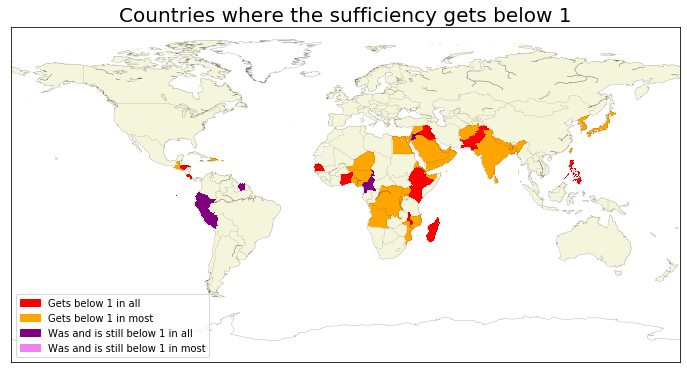

In [376]:
# Cases: 
#0: all get bellow 1 
#1: most get bellow 1

#2: was belown 1 and still in all
#3: was belown 1 and still in most

#4: other

fig, ax = plt.subplots(figsize=(12, 8))

sufficiencies['get_below'] = 4
for i, country in sufficiencies.iterrows():
    state = 6
    # If country is sufficient in 2000
    if country['2000'] >= 1: 
        start = 1
    else: 
        start = 0        
    diff = 0
    for ssp in climate_scenarios:
        # sufficient in 2000 but not in 2050
        if start == 1 and country[ssp] < 1:
            diff += 1
        # not sufficient in 2000 but sufficient in 2050
        elif start == 0 and country[ssp] > 1:
            diff += 1
    
    # Compare diff values
    #0: all get bellow 1
    if start == 1 and diff == 5: 
        state = 0
    #1: most get bellow 1    
    elif start == 1 and diff == 4:
        state = 1
    #2: was belown 1 and still in all    
    elif start == 0 and diff == 0:
        state = 2
    #3: was belown 1 and still in most
    elif start == 0 and diff == 1:
        state = 3
              
    
    sufficiencies.at[i, 'get_below'] = state
            

prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
suff_all = prod.join(sufficiencies.set_index('ISO3'), on='ISO3')

title = 'Countries where the sufficiency gets below 1'
visualize_sufficiency_below(suff_all, fig, ax, title, savefig=True)

In [379]:
# Useful to do the QGIS plot
sufficiencies['plot'] = -1
for i, row in sufficiencies.iterrows():
    sufficiencies.loc[i, 'plot'] = str(row['all_ssp']) + str(row['get_below'])

In [380]:
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,all_ssp,get_below,plot
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968,0,2,02
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733,2,2,22
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535,3,6,36
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497,0,2,02
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429,0,6,06


In [381]:
sufficiencies.to_csv(suff_path + 'suff_map.csv')

## Infos countries

In [374]:
sufficiencies = pd.read_csv(suff_path + 'country_sufficiencies.csv')
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5
0,AFG,0.785233,0.493153,0.425091,0.325974,0.299583,0.652968
1,AGO,0.597733,0.479125,0.645777,0.397626,0.618204,0.775733
2,ALB,2.319537,2.451543,2.413065,2.508424,2.482484,2.448535
3,ARE,0.403014,0.158618,0.152754,0.143927,0.179645,0.109497
4,ARG,8.343864,5.579057,6.410061,6.399189,5.945983,6.103429


In [370]:
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
len(countries_names)

254

In [371]:
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')

countries.head()

,country_id,pixel_id,base_id,ISO3,name,sovereignt
0,91.0,330087.0,91,GRL,Greenland,Denmark
1,91.0,330088.0,91,GRL,Greenland,Denmark
2,91.0,330089.0,91,GRL,Greenland,Denmark
3,91.0,330090.0,91,GRL,Greenland,Denmark
4,91.0,334378.0,91,GRL,Greenland,Denmark


In [372]:
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')

pop_dir = pop_path
pop = pd.read_csv(os.path.join(pop_dir,'pop_2000.csv'))
pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
pop_bycountry_2000 = pop.groupby('ISO3')['gpw_population'].sum()

prod = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
prod_bycountry_2000 = prod.groupby('ISO3')['calories_2000'].sum()

diets = pd.read_csv(diet_path + 'pctLS_SSPs_Bodirsky.csv',sep=';')

In [363]:
def get_changes(country):
    changes = pd.DataFrame(columns=['2000', 'Change SSP1', 'Change SSP2', 'Change SSP3', 'Change SSP4', 'Change SSP5'], 
                           index=['Caloric Sufficiency', 'Production', 'Population', 'Cropland', 'Livestock'])
    
    changes = changes.rename_axis(countries[countries['ISO3'] == country].name.iloc[0], axis=1)
    
    # sufficiency 2000
    changes.at['Caloric Sufficiency', '2000'] = sufficiencies[sufficiencies['ISO3'] == country]['2000'].values[0]
    # population 2000
    changes.at['Population', '2000'] = pop_bycountry_2000[country]
    # production 2000
    changes.at['Production', '2000'] = prod_bycountry_2000[country]
    # livestock 2000
    try:
        changes.at['Livestock', '2000'] = diets[(diets['Scenario'] == 'ssp1') & (diets['Region'] == country)]['2000'].values[0]
    except:
        changes.at['Livestock', '2000'] = np.nan
        pass
    
    df = pd.read_csv(os.path.join(compare_path, 'ssp1'+'_compare.csv'), index_col='pixel_id')
    # cropland 2000
    df['cropland_2000'] = df.dropna(subset=['calories_2000'])['ha_per_pixel'] * df.dropna(subset=['calories_2000'])['%cropland_2000']
    changes.at['Cropland', '2000'] = df.groupby('ISO3')['cropland_2000'].sum()[country]
    
    
    for ssp in climate_scenarios:
        name = 'Change ' + ssp.upper()
        df = pd.read_csv(os.path.join(compare_path, ssp+'_compare.csv'), index_col='pixel_id', na_values=[-9999])
        # change in caloric sufficicency
        changes.at['Caloric Sufficiency', name] = sufficiencies[sufficiencies['ISO3'] == country][ssp].values[0]
        
        # change in population
        pop = pd.read_csv(os.path.join(pop_dir,'pop_' + ssp + '.csv'))
        pop = pop.merge(countries, right_on='pixel_id', left_on='pixel_id')
        pop_bycountry = pop.groupby('ISO3')['gpw_population'].sum()
        
        change_pop = (pop_bycountry[country] - changes.at['Population', '2000']) / changes.at['Population', '2000']
        changes.at['Population', name] = '{:+,.2f}%'.format(100*change_pop)
        
        # change in production
        prod_bycountry = df.groupby('ISO3')['calories_2050'].sum() 
        change_prod = (prod_bycountry[country] - changes.at['Production', '2000']) / changes.at['Production', '2000']
        changes.at['Production', name] = '{:+,.2f}%'.format(100*change_prod)
        
        # change in cropland
        df['cropland_2050'] = df['ha_per_pixel'] * df['%cropland_2050']
        change_cropland = (df.groupby('ISO3')['cropland_2050'].sum()[country] - changes.at['Cropland', '2000']) / changes.at['Cropland', '2000']
        changes.at['Cropland', name] = '{:+,.2f}%'.format(100*change_cropland)
        
        # livestock
        try:
            changes.at['Livestock', name] = diets[(diets['Scenario'] == ssp) & (diets['Region'] == country)]['2050'].values[0]
        except:
            changes.at['Livestock', name] = np.nan
            pass
    # invert axis (transpose df)
    return changes.T 

In [309]:
# Japan
get_changes('JPN')

,Caloric Sufficiency,Production,Population,Cropland,Livestock
Japan,,,,,
2000,0.793248,1.02564e+17,1.18106e+08,7.59592e+06,0.1564
Change SSP1,0.998118,-1.96%,-5.20%,-2.30%,0.1423
Change SSP2,0.933332,+0.55%,+1.30%,+0.76%,0.1539
Change SSP3,0.904337,-6.02%,+1.30%,-6.04%,0.1541
Change SSP4,0.997438,+9.40%,+0.89%,+9.59%,0.1341
Change SSP5,0.943213,+9.75%,+0.50%,+8.85%,0.1913


In [245]:
# India
get_changes('IND')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


India,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.03828e+09,+27.33%,+17.54%,+111.56%,+29.90%,+27.00%
Caloric Sufficiency,0.653553,0.588175,0.639735,0.421744,0.582959,0.639958
Production,1.1043e+18,+30.15%,+35.82%,+45.47%,+33.98%,+47.07%
Cropland,2.16572e+08,-4.24%,+0.99%,+7.31%,-0.98%,+8.29%
Livestock,0.0762,0.211,0.1817,0.1406,0.177,0.1787


In [182]:
# Brazil
get_changes('BRA')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Brazil,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.68511e+08,0.127831,0.127917,0.128668,0.128121,0.127831
Caloric Sufficiency,3.64748,3.31226,3.51964,3.36292,3.15167,4.12829
Production,1.00013e+18,0.24303,0.341857,0.304493,0.180426,0.606187
Cropland,1.86143e+08,0.131912,0.220752,0.183569,0.0738063,0.460558
Livestock,0.2204,0.2727,0.2586,0.2106,0.2599,0.261


In [246]:
# France
get_changes('FRA')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


France,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,5.90026e+07,+6.84%,+6.87%,+7.71%,+7.10%,+7.35%
Caloric Sufficiency,5.40715,3.17037,3.25941,3.59111,3.15217,3.15161
Production,5.18418e+17,-35.95%,-33.94%,-26.81%,-36.06%,-40.10%
Cropland,2.73751e+07,-5.12%,+0.46%,+11.05%,-3.16%,-1.61%
Livestock,0.37,0.1972,0.2105,0.28,0.1911,0.3045


In [184]:
# USA
print('USA')
get_changes('USA')

USA


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


United States of America,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,2.75032e+08,0.0963864,0.0963863,0.0964063,0.0963863,0.968284
Caloric Sufficiency,5.52503,3.40373,3.5207,4.00427,4.0778,2.31963
Production,2.47476e+18,-0.216114,-0.189611,-0.0741521,-0.0184627,-0.197242
Cropland,1.87416e+08,-0.0792915,-0.0240776,0.0930925,0.17213,-0.0176368
Livestock,0.2656,0.1852,0.2006,0.2481,0.1809,0.2644


In [185]:
# China
print('China')
get_changes('CHN')

China


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


China,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.25246e+09,0.0507877,0.0542715,0.0542755,0.0501957,0.0508146
Caloric Sufficiency,1.41497,1.29027,1.42406,1.25421,1.4072,1.45511
Production,2.88644e+18,-0.0808103,0.0620928,-0.0745808,0.0398189,0.0967482
Cropland,2.68538e+08,-0.139182,0.00293515,-0.142667,-0.0136646,0.0273642
Livestock,0.1864,0.3608,0.3521,0.2734,0.3544,0.3385


In [186]:
# Namibia
print('Namibia')
get_changes('NAM')

Namibia


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Namibia,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.81974e+06,0.499067,0.566891,1.01576,1.28288,0.494885
Caloric Sufficiency,1.93292,2.78807,3.81264,9.1961,2.91245,5.31636
Production,4.25569e+15,2.75114,4.55381,17.3979,5.05485,6.58276
Cropland,1.43441e+06,0.961642,1.70395,8.39617,1.98466,2.96142
Livestock,0.1718,0.2263,0.2142,0.1721,0.2063,0.2058


In [187]:
# South Africa
print('South Africa')
get_changes('ZAF')

South Africa


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


South Africa,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,4.42538e+07,0.14883,0.14888,0.149287,0.148935,0.66108
Caloric Sufficiency,1.5465,1.3234,1.34338,3.25445,1.27107,1.23845
Production,1.1005e+17,0.163359,0.188428,2.32602,0.110268,0.560456
Cropland,1.56778e+07,0.0948852,0.0954242,1.94529,0.0518128,0.455773
Livestock,0.1214,0.2155,0.2103,0.1732,0.2099,0.2026


In [188]:
# Bostswana
print('Bostswana')
get_changes('BWA')

Bostswana


/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Botswana,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.70327e+06,0.170494,0.176752,0.1786,0.16583,0.189763
Caloric Sufficiency,1.38043,3.76267,3.88242,22.6173,4.5512,4.66115
Production,2.35535e+15,5.96184,6.25802,44.4839,7.50906,7.93901
Cropland,2.31606e+06,0.491526,0.524649,8.25445,0.85189,0.837301
Livestock,0.1642,0.2197,0.2137,0.1779,0.2147,0.2068


In [189]:
# Mexico
get_changes('MEX')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mexico,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.01362e+08,0.152776,0.153486,1.14982,0.15392,0.155814
Caloric Sufficiency,1.43522,1.18683,1.26837,0.834653,1.37688,1.2154
Production,2.35589e+17,-0.0808405,0.0163119,-0.00895786,0.141756,-0.0437017
Cropland,3.13675e+07,-0.0862836,0.00641325,-0.0106919,0.143462,-0.0516755
Livestock,0.1788,0.2364,0.2322,0.1949,0.2326,0.2335


In [190]:
# Russia
get_changes('RUS')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Russia,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.45662e+08,-0.0347538,-0.0288861,-0.0299316,-0.0363294,-0.0325875
Caloric Sufficiency,3.81728,4.81829,4.90142,4.58175,4.83571,4.86473
Production,9.04621e+17,0.581047,0.623256,0.529835,0.584988,0.600544
Cropland,1.74761e+08,0.0413037,0.0643916,0.00526931,0.0380344,0.0534672
Livestock,0.2094,0.2666,0.2638,0.2299,0.2658,0.268


In [191]:
# Morocco
get_changes('MAR')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Morocco,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,2.83191e+07,0.113823,0.113823,0.11468,0.113823,0.113823
Caloric Sufficiency,0.511462,1.08182,0.883328,0.828717,0.850426,0.624719
Production,2.21268e+16,2.15215,1.50013,1.37374,1.39939,0.630808
Cropland,7.35527e+06,0.572136,0.28324,0.223022,0.235202,-0.191055
Livestock,0.0671,0.1888,0.1755,0.1365,0.1677,0.1652


In [192]:
# Algeria
get_changes('DZA')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Algeria,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,3.04661e+07,0.155185,0.160759,1.05026,0.155294,0.155185
Caloric Sufficiency,0.440654,1.14768,0.996826,0.676069,0.938685,0.856801
Production,2.04009e+16,2.95242,2.38111,2.66655,2.12548,1.77977
Cropland,5.82716e+06,1.23274,0.933442,1.032,0.846187,0.559981
Livestock,0.0958,0.1769,0.1607,0.1391,0.1599,0.1629


In [193]:
# Netherlands
get_changes('NLD')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Netherlands,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.54964e+07,0.0477205,0.0477205,0.0476818,0.0477205,0.0477205
Caloric Sufficiency,0.678164,1.1744,1.1907,1.21616,1.19129,1.19658
Production,1.56492e+16,-0.15112,-0.11354,-0.0754566,-0.107484,-0.143293
Cropland,903441,-0.137198,-0.0958366,-0.0554623,-0.0880306,-0.109074
Livestock,0.3395,0.2361,0.2375,0.2568,0.2337,0.2756


In [194]:
# Argentina
get_changes('ARG')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Argentina,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,3.66853e+07,0.110495,0.111212,0.114619,0.113666,0.110282
Caloric Sufficiency,7.93149,5.89047,6.70144,6.24903,6.20517,6.3671
Production,4.7268e+17,-0.0044652,0.155744,0.0952234,0.0629888,0.0910136
Cropland,6.12912e+07,0.00985001,0.177398,0.114788,0.0829646,0.0735377
Livestock,0.307,0.3329,0.3262,0.2731,0.3239,0.3241


In [195]:
# Chile
get_changes('CHL')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Chile,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.48874e+07,0.118402,0.118854,0.119498,0.118421,0.118458
Caloric Sufficiency,2.21728,1.68913,1.79427,1.97391,1.9579,1.71404
Production,5.23152e+16,-0.0825614,-0.00661399,0.143,0.11322,-0.0715054
Cropland,4.72577e+06,-0.0532529,0.0418674,0.24585,0.162173,-0.0265587
Livestock,0.2182,0.2563,0.2592,0.2304,0.2585,0.2709


In [196]:
# Saudi Arabia
get_changes('SAU')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Saudi Arabia,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,2.11984e+07,1.62517,1.63038,1.63169,1.63183,1.63939
Caloric Sufficiency,0.630262,0.54188,0.585503,0.689004,0.553992,0.544274
Production,2.02958e+16,0.486329,0.768705,1.46122,0.568797,0.48783
Cropland,1.52304e+06,0.712532,1.10035,1.90098,0.861445,0.748748
Livestock,0.1442,0.1921,0.1946,0.1859,0.1922,0.2056


In [197]:
# Nigeria
get_changes('NGA')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Nigeria,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.21437e+08,1.58527,1.59766,2.6354,2.80373,1.58523
Caloric Sufficiency,0.955237,0.476895,0.533073,0.386782,0.351511,0.527983
Production,1.87557e+17,0.701304,0.956057,0.930791,0.800899,0.928792
Cropland,5.49196e+07,0.0197826,0.17943,0.165711,0.0911736,0.173091
Livestock,0.0258,0.1607,0.1437,0.1201,0.1248,0.1413


In [198]:
# Mozambique
get_changes('MOZ')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mozambique,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.75943e+07,1.61295,1.66442,1.69749,1.68621,1.6029
Caloric Sufficiency,0.887487,0.587503,0.649156,0.407717,0.525732,0.691925
Production,2.39692e+16,1.34148,1.73236,0.623787,1.19763,1.85143
Cropland,9.06879e+06,0.164468,0.357399,0.305736,0.772564,0.394472
Livestock,0.0557,0.1748,0.139,0.1201,0.1144,0.1487


In [199]:
# Angola
get_changes('AGO')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Angola,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.52012e+07,1.77479,1.78527,2.94943,3.10288,1.77517
Caloric Sufficiency,0.591377,0.453087,0.571087,0.381656,0.558107,0.686487
Production,1.31731e+16,1.71236,2.68496,2.14233,4.29108,3.53558
Cropland,6.25171e+06,0.150732,0.569389,0.325331,1.24975,0.92088
Livestock,0.0721,0.1531,0.1337,0.1236,0.1301,0.1468


In [200]:
# Niger
get_changes('NER')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Niger,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.12626e+07,2.93483,3.2408,4.58144,4.61001,1.89653
Caloric Sufficiency,0.673067,0.524753,0.427274,0.436517,0.396584,0.757167
Production,1.08769e+16,2.48528,1.89523,2.9988,2.50975,3.2411
Cropland,9.77562e+06,-0.138318,0.195172,0.409248,0.269513,0.0439301
Livestock,0.1014,0.2267,0.1611,0.1424,0.125,0.2056


In [201]:
# Madagascar
get_changes('MDG')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Madagascar,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.55127e+07,1.6522,1.66796,2.72722,2.70718,1.65198
Caloric Sufficiency,1.10678,0.629035,0.572517,0.312999,0.561928,0.614039
Production,2.65024e+16,0.886332,0.733926,0.0638388,1.39504,0.854447
Cropland,6.72388e+06,0.292325,0.196461,0.076361,1.34937,0.264166
Livestock,0.0787,0.188,0.1456,0.1298,0.1204,0.1669


In [202]:
# Ghana
get_changes('GHA')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Ghana,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,1.86764e+07,1.53347,1.57565,1.59155,1.57804,1.51137
Caloric Sufficiency,1.06665,0.581259,0.608303,0.523676,0.603281,0.776556
Production,3.09868e+16,0.836034,0.993141,0.70205,1.00477,1.55901
Cropland,1.06269e+07,0.0533093,0.141649,-0.02854,0.146009,0.448843
Livestock,0.0233,0.1502,0.1301,0.1128,0.1083,0.1346


In [203]:
# DRC
get_changes('COD')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Democratic Republic of the Congo,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,4.74098e+07,1.70056,1.72799,2.64925,2.68819,1.70054
Caloric Sufficiency,0.46579,0.577997,0.616675,0.278031,0.440682,0.537773
Production,3.45098e+16,3.09289,3.53785,1.29533,3.40783,2.7251
Cropland,1.23407e+07,1.36326,1.60893,1.00155,2.31931,1.13183
Livestock,0.0131,0.1244,0.1134,0.1027,0.0944,0.125


In [204]:
# Kenya
get_changes('KEN')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Kenya,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,3.04372e+07,1.57216,1.58849,2.22049,1.61504,1.56615
Caloric Sufficiency,1.04054,0.640422,0.764475,0.556241,0.673315,0.763321
Production,5.01344e+16,0.745013,1.2691,0.891152,0.999407,1.21615
Cropland,1.3424e+07,0.134788,0.471251,0.219386,0.293403,0.419297
Livestock,0.1011,0.2187,0.1758,0.1459,0.1365,0.1973


In [205]:
# Ethiopia
get_changes('ETH')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Ethiopia,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,6.63836e+07,1.52664,1.5847,1.56993,1.61311,1.50518
Caloric Sufficiency,1.03491,0.525376,0.610268,0.513146,0.448758,0.834606
Production,1.10478e+17,0.6908,1.08907,0.74905,0.532318,1.83558
Cropland,2.48968e+07,0.146594,0.460153,0.842992,0.616838,1.0102
Livestock,0.0366,0.2004,0.1567,0.1246,0.1227,0.1588


In [206]:
# Tanzania
get_changes('TZA')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Tanzania,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,3.33032e+07,1.6374,1.66135,2.69788,2.77858,1.63
Caloric Sufficiency,1.36481,0.802822,0.879453,0.567635,0.62196,1.76561
Production,7.25922e+16,0.905735,1.19561,0.962506,1.24844,3.71857
Cropland,2.2294e+07,0.1074,0.292979,0.152136,0.317852,1.62687
Livestock,0.0535,0.1971,0.1589,0.1319,0.1288,0.167


In [207]:
# Guinea
get_changes('GIN')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Guinea,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,8.36134e+06,0.291336,1.48171,1.51914,1.51706,0.270525
Caloric Sufficiency,1.42002,1.56101,1.02825,0.892672,0.820734,1.83063
Production,1.78722e+16,1.16321,1.73597,1.43388,1.22469,1.55773
Cropland,5.0817e+06,0.297269,0.651494,0.456394,0.339677,0.534204
Livestock,0.0272,0.1825,0.1476,0.1169,0.1158,0.1463


In [208]:
# Senegal
get_changes('SEN')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Senegal,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,9.07838e+06,1.51969,1.59563,2.62573,2.48567,0.659272
Caloric Sufficiency,1.51919,0.743025,0.861439,0.546296,0.658211,1.12119
Production,2.09986e+16,0.631535,1.03839,0.664718,1.02635,0.741172
Cropland,6.08544e+06,-0.0387108,0.222741,-0.00985914,0.212097,0.0518327
Livestock,0.0532,0.1721,0.1392,0.1226,0.1142,0.1539


In [209]:
# Columbia
get_changes('COL')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Colombia,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,3.99123e+07,0.132079,0.302875,0.89242,0.136945,0.132006
Caloric Sufficiency,1.31095,1.07169,1.15898,0.847382,1.2616,1.25184
Production,8.37881e+16,-0.0775943,0.196335,0.12923,0.172983,0.157712
Cropland,1.38334e+07,-0.168642,0.0812778,0.0194516,0.0535256,0.0418003
Livestock,0.1701,0.2682,0.2522,0.2009,0.251,0.2479


In [210]:
# Mongolia
get_changes('MNG')

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mongolia,2000,Change SSP1,Change SSP2,Change SSP3,Change SSP4,Change SSP5
Population,2.40824e+06,0.130528,0.153014,0.945853,0.130618,0.130471
Caloric Sufficiency,5.24766,10.6675,12.7449,6.06443,10.5973,10.7885
Production,1.91178e+16,1.97889,2.70469,1.91198,1.98186,2.08821
Cropland,7.91336e+06,0.28559,0.555061,0.245529,0.277222,0.295549
Livestock,0.4242,0.5679,0.5305,0.3798,0.5344,0.4726


## Information about changes in every country 

In [364]:
# Creating Excel Writer Object from Pandas  
writer = pd.ExcelWriter(suff_fig_path + 'country_info.xlsx', engine='xlsxwriter')   
workbook = writer.book
worksheet = workbook.add_worksheet('Country_results')
writer.sheets['Country_results'] = worksheet

country_list = sufficiencies['ISO3'].values
start_row = 0
done = 0
for country in country_list:
    done += 1
    # compute information about the country
    changes = get_changes(country)
    # write to excel file
    changes.to_excel(writer, sheet_name='Country_results', startrow=start_row, startcol=0, index=True)
    start_row += len(changes) + 2
    print(f'{done}/{len(country_list)}')

# save excel file
writer.save()

1/166
2/166
3/166
4/166
5/166
6/166
7/166
8/166
9/166
10/166
11/166
12/166
13/166
14/166
15/166
16/166
17/166
18/166
19/166
20/166
21/166
22/166
23/166
24/166
25/166
26/166
27/166
28/166
29/166
30/166
31/166
32/166
33/166
34/166
35/166
36/166
37/166
38/166
39/166
40/166
41/166
42/166
43/166
44/166
45/166
46/166
47/166
48/166
49/166
50/166
51/166
52/166
53/166
54/166
55/166
56/166
57/166
58/166
59/166
60/166
61/166
62/166
63/166
64/166
65/166
66/166
67/166
68/166
69/166
70/166
71/166
72/166
73/166
74/166
75/166
76/166
77/166
78/166
79/166
80/166
81/166
82/166
83/166
84/166
85/166
86/166
87/166
88/166
89/166
90/166
91/166
92/166
93/166
94/166
95/166
96/166
97/166
98/166
99/166
100/166
101/166
102/166
103/166
104/166
105/166
106/166
107/166
108/166
109/166
110/166
111/166
112/166
113/166
114/166
115/166
116/166
117/166
118/166
119/166
120/166
121/166
122/166
123/166
124/166
125/166
126/166
127/166
128/166
129/166
130/166
131/166
132/166
133/166
134/166
135/166
136/166
137/166
138/166
139/